Goald of this notebook is to get the sentiment of a tweet. This is done by labelling those tweets with only positive emojis as positive, and those with only negative as negative. Once this ground truth is generated we can train a model to get the sentiment.  
In order to get an interpretable model, logistic regressin with L1 regularisation is applied in order to get a sparse (and hence even more interpretable) solution.

In [2]:
import nltk
from nltk.corpus import stopwords
import re

In [3]:
import commands as cmd

root_path = cmd.getoutput('pwd')[:cmd.getoutput('pwd').find('/databeers/')] + '/databeers'

import sys
sys.path.append(root_path)

In [4]:
import commands
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
%matplotlib inline

from src.read_write_utils import *
from src.analysis_utils import *
from src.utils import *

In [5]:
begin_time = datetime(2016, 7, 26)
end_time = datetime(2016, 8, 1)
ta = TweetsAnalysis(begin_time, end_time, root_path)

In [6]:
country_code_dict = {"es": "spanish", "pt": "portuguese", "fr": "french", "de": "german",
 "it": "italian", "nl": "dutch", "tr": "turkish", "ru": "russian"}

In [7]:
df = load_joined_df(begin_time, end_time, root_path=root_path, columns = ["text", "id_str", "lang"])
print len(df)
df = df[df["lang_x"] == "en"]
print len(df)

1009658
657091


In [8]:
len(stopwords.words("english"))

153

In [9]:
def preprocess_tweet(raw_tweet, language_code):
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z#]", " ", raw_tweet) 
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()
    # Use set since it is hash based and hence faster
    stops = set(stopwords.words(country_code_dict.get(language_code, "english")))             
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    return " ".join(meaningful_words)  

In [10]:
df["cleaned_text"] = np.vectorize(preprocess_tweet)(df['text'], df['lang_x'])

In [12]:
df["pos"] = df['text'].str.contains(pos_emojis)
df["neg"] = df['text'].str.contains(neg_emojis)
        

/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':
/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


In [13]:
filtered_df = df[np.vectorize(np.logical_xor)(df["pos"], df["neg"])]
print len(filtered_df)

32345


In [16]:
cleaned_df = remove_similar_tweets(filtered_df)

/home/paul/Documents/databeers/src/analysis_utils.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["tweet_clean"] = np.vectorize(TweetsAnalysis.preprocess_tweet)(df[text_col], df[lang_col])


3.7393078804 cleaned tweets
12.2426900864 created lsh
True     16571
False    15774
Name: select, dtype: int64
0.107950925827 selected df


/home/paul/Documents/databeers/src/analysis_utils.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['select'] = pd.Series([idx_selected.get(idx, False) for idx in df_indices], index=df_indices)


In [17]:
filtered_df.columns

Index([u'lang_x', u'user_id', u'text', u'day_str', u'id_str_x', u'lang_y',
       u'id', u'id_str_y', u'cleaned_text', u'pos', u'neg', u'tweet_clean',
       u'select'],
      dtype='object')

In [18]:
df_cleaned_lsh = filtered_df

## create features for LR via Bag of Words

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
n_words = 300
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = ["rt", "smh", "tf", "dm"],   
                             max_features = n_words)



In [75]:
msk = np.random.rand(len(cleaned_df)) < 0.9
train_data_features = vectorizer.fit_transform(cleaned_df["tweet_clean"][msk])
test_data_features = vectorizer.transform(cleaned_df["tweet_clean"][~msk])


In [76]:
# also remove very frequent words since they do not add more value
idx_to_remove = []
for idx, zipped in enumerate(zip(vectorizer.get_feature_names(), np.asarray(np.sum(train_data_features, axis=0))[0])):
    word, n = zipped
                            
    if n *1.0 / train_data_features.shape[0] > 0.05:
        print word, n, n * 1.0/ train_data_features.shape[0]
        idx_to_remove.append(idx)

amp 1077 0.0724618179372
beer 13101 0.881450581982
co 5726 0.385251967974
drink 770 0.0518064993608
drinking 940 0.063244297921
https 5773 0.38841418287
like 883 0.059409271345


In [77]:
idx_to_remove

[7, 20, 48, 66, 67, 141, 155]

In [78]:
train_data_features.toarray().shape

(14863, 300)

In [79]:
print len(pd.to_numeric(cleaned_df[msk]["pos"]))
print train_data_features.toarray().shape

14863
(14863, 300)


In [80]:
df_uq = pd.DataFrame(train_data_features.toarray())
df_uq["label"] = pd.Series(cleaned_df[msk]["pos"].map({True: 1, False: 0}).values)
df_uq = df_uq.drop_duplicates()

In [81]:
len(df_uq)

11383

## model

In [82]:
from sklearn.linear_model import LogisticRegression, ElasticNetCV, LogisticRegressionCV
from sklearn.metrics import make_scorer, auc, roc_auc_score, roc_curve

In [83]:
lr_model = LogisticRegressionCV(penalty='l1', solver="liblinear", scoring=make_scorer(roc_auc_score))


In [84]:
lr_model.fit(df_uq[range(n_words)].values, df_uq["label"].values)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=make_scorer(roc_auc_score),
           solver='liblinear', tol=0.0001, verbose=0)

In [85]:
lr_model.fit(train_data_features, cleaned_df["pos"][msk].values)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=make_scorer(roc_auc_score),
           solver='liblinear', tol=0.0001, verbose=0)

train auc 0.706171080424


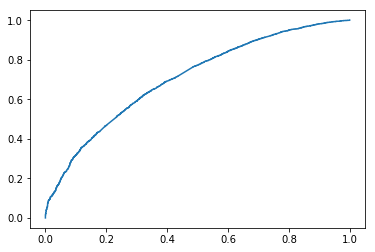

In [86]:
roc_data = roc_curve(pd.to_numeric(cleaned_df[msk]["pos"]), [x[1] for x in lr_model.predict_proba(train_data_features.toarray())])
plt.plot(roc_data[0].tolist(), roc_data[1].tolist())
print 'train auc', auc(roc_data[0], roc_data[1])

test auc 0.650719098302


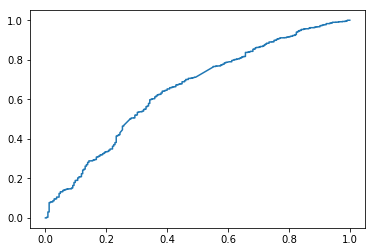

In [87]:
roc_data = roc_curve(pd.to_numeric(cleaned_df[~msk]["pos"]), [x[1] for x in lr_model.predict_proba(test_data_features.toarray())])
plt.plot(roc_data[0].tolist(), roc_data[1].tolist())
print 'test auc', auc(roc_data[0], roc_data[1])

In [43]:
lr_model.intercept_

array([ 1.65492764])

In [44]:
min(lr_model.coef_[0]), max(lr_model.coef_[0])

(-2.824675878300118, 6.9094005200409896)

In [45]:
similar(*filtered_df[filtered_df["text"].str.lower().str.contains("explorer")]["text"].values[0:2])

0.9005847953216374

In [89]:
for v, feat in sorted(zip(lr_model.coef_[0], vectorizer.get_feature_names()), key=lambda x: x[0]):
    if abs(v) > 1:
        print v, feat

-1.55264631435 miss
-1.36817905022 hate
-1.28262319351 wish
-1.02502225543 fucking
1.00424573609 great
1.05965672746 awesome
1.06597815901 hey
1.09429115222 thanks
1.13185189717 sun
1.14539521307 perfect
1.21661453491 tweet
1.24213621901 maybe
1.52612425185 thank
1.65493422776 mate
1.74489781121 haha
2.0818206506 cheers
2.39478368858 chase


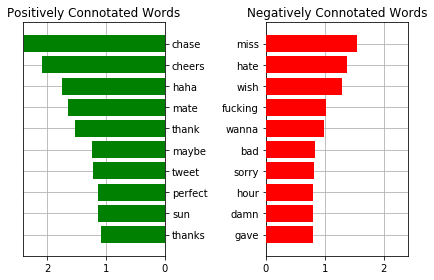

In [90]:
plot_top_n = 10
coeffs = sorted(zip(lr_model.coef_[0], vectorizer.get_feature_names()), key=lambda x: x[0])

fig, axes = plt.subplots(ncols=2)
y = range(plot_top_n)
axes[0].barh(y, [x[0] for x in coeffs[-plot_top_n:]], align='center', color='green', zorder=10)
axes[0].set(title='Positively Connotated Words')
negs = coeffs[:plot_top_n]
negs.reverse()
axes[1].barh(y, [abs(x[0]) for x in negs], align='center', color='red', zorder=10)
axes[1].set(title='Negatively Connotated Words')

axes[0].set_ylim((-1, plot_top_n))
axes[1].set_ylim((-1, plot_top_n))

x_lim = max(coeffs[0][0], coeffs[-1][0]) * 1.01
axes[0].set_xlim((0, x_lim))
axes[1].set_xlim((0, x_lim))

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=[x[1] for x in coeffs[-plot_top_n:]])
axes[0].yaxis.tick_right()

axes[1].set(yticks=y, yticklabels=[x[1] for x in negs])

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.71)

Although model performance is not so great, the feature importance which we want makes sense!

In [91]:
for x in coeffs:
    if x[1] in ("warm", "cold"):
        print x[1], x[0]

cold -0.0858306386896


In [112]:
print "Training the random forest..."
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(oob_score=True, max_features=3) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run

param_grid = {
                 'n_estimators': [100],
                 'max_depth': [15, 25, 50],
                 'max_features': [1, 2, 3, 4, 'log2']
             }
grid_clf = GridSearchCV(forest, param_grid, cv=10, scoring='roc_auc')
grid_clf.fit(train_data_features.toarray(), pd.to_numeric(cleaned_df[msk]["pos"]))

Training the random forest...


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'max_features': [1, 2, 3, 4, 'log2'], 'max_depth': [15, 25, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [113]:
grid_clf.grid_scores_

/home/paul/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.63228, std: 0.01922, params: {'max_features': 1, 'n_estimators': 100, 'max_depth': 15},
 mean: 0.63413, std: 0.02641, params: {'max_features': 2, 'n_estimators': 100, 'max_depth': 15},
 mean: 0.63535, std: 0.02256, params: {'max_features': 3, 'n_estimators': 100, 'max_depth': 15},
 mean: 0.63434, std: 0.02591, params: {'max_features': 4, 'n_estimators': 100, 'max_depth': 15},
 mean: 0.63291, std: 0.02461, params: {'max_features': 'log2', 'n_estimators': 100, 'max_depth': 15},
 mean: 0.63261, std: 0.02336, params: {'max_features': 1, 'n_estimators': 100, 'max_depth': 25},
 mean: 0.63706, std: 0.02405, params: {'max_features': 2, 'n_estimators': 100, 'max_depth': 25},
 mean: 0.64059, std: 0.02565, params: {'max_features': 3, 'n_estimators': 100, 'max_depth': 25},
 mean: 0.63431, std: 0.02607, params: {'max_features': 4, 'n_estimators': 100, 'max_depth': 25},
 mean: 0.63640, std: 0.02354, params: {'max_features': 'log2', 'n_estimators': 100, 'max_depth': 25},
 mean: 0.62526, std:

In [114]:
forest = grid_clf.best_estimator_
sum(forest.feature_importances_)

1.0000000000000002

In [115]:
for v, feat in sorted(zip(forest.feature_importances_, vectorizer.get_feature_names()), key=lambda x: x[0], reverse=True)[:20]:
    print v, feat

0.0285751399541 https
0.0276801953581 co
0.0193890777862 want
0.017715413459 beer
0.0144085772274 miss
0.0138034858715 amp
0.0101462069284 wish
0.0100999254797 like
0.0100291736322 hate
0.00943041185451 drink
0.00938561453249 wanna
0.00928973990866 bad
0.00898854164368 get
0.00878898131827 fucking
0.00818942218262 go
0.00805881442813 root
0.00786822379087 need
0.00773564801626 work
0.00769231165788 good
0.0076292085404 one


In [96]:
forest.oob_score_

0.85850770369373608

In [97]:
train_data_features.toarray().shape

(14863, 300)

In [98]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print len(vocab)

300


In [99]:
"lager" in vocab

False

In [100]:
"ipa" in vocab

True

In [101]:
"pils" in vocab

False

In [102]:
"pilsner" in vocab

False

In [103]:
"heineken" in vocab

False

In [104]:
"paulaner" in vocab

False

In [105]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print count, tag


[[   73    84   114    66   104   130   191  1077   130    76    70   107
    159    94    79   252   153   153    71    81 13101    80    76   245
    228    98   134    81   185   131    86    77    70   132    62    63
     67   313    78    61    81    70    99   106    62   139    71    67
   5726    98   346   296    67    73    73   162   198    93    83   223
     82   447    97    94   110   111   770   940    94   154    97    77
     71    89   134    87   238   143   126   132    67    90   108    66
    111    64    95   231    68   266    66   233   121   110   110   165
    132    92    85   130   156   142    77   676    91   182    66   123
     67   136    84   452    68    78   266   162   658   479    89   380
     82    70   143   144   116    72   130   232    84    67    77    72
     62    97    63   235   142   127    70    63   196  5773   118    64
    128    87   113    75    87   329   301    92   168   203    83   883
     83    63    76   111    94   114 

In [106]:
zip(vocab, dist.A1)

[(u'actually', 73),
 (u'alcohol', 84),
 (u'ale', 114),
 (u'almost', 66),
 (u'already', 104),
 (u'also', 130),
 (u'always', 191),
 (u'amp', 1077),
 (u'another', 130),
 (u'around', 76),
 (u'ask', 70),
 (u'asked', 107),
 (u'ass', 159),
 (u'away', 94),
 (u'awesome', 79),
 (u'back', 252),
 (u'bad', 153),
 (u'bar', 153),
 (u'bc', 71),
 (u'beach', 81),
 (u'beer', 13101),
 (u'beers', 80),
 (u'belly', 76),
 (u'best', 245),
 (u'better', 228),
 (u'big', 98),
 (u'birthday', 134),
 (u'bong', 81),
 (u'bottle', 185),
 (u'bottles', 131),
 (u'bought', 86),
 (u'brewery', 77),
 (u'brewing', 70),
 (u'bring', 132),
 (u'bro', 62),
 (u'brother', 63),
 (u'butter', 67),
 (u'buy', 313),
 (u'came', 78),
 (u'cans', 61),
 (u'car', 81),
 (u'case', 70),
 (u'cause', 99),
 (u'chase', 106),
 (u'check', 62),
 (u'cheers', 139),
 (u'cheese', 71),
 (u'chill', 67),
 (u'co', 5726),
 (u'coffee', 98),
 (u'cold', 346),
 (u'come', 296),
 (u'coming', 67),
 (u'company', 73),
 (u'cool', 73),
 (u'could', 162),
 (u'craft', 198),
 (u'

The random forest doesn't work as well since it has problems if many values are 0. The maximum gain in gini impurity is low, even if the separation is perfect at this feature